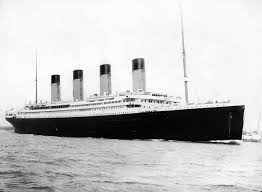

Importing libraries:

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os

Loading in our csv from Github URL:

In [ ]:
train = pd.read_csv('/train.csv')
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Some basic EDA:

In [ ]:
# Do we have any blanks in our data?
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
train.shape

(891, 12)

In [ ]:
# Gender Distribution
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
# Survival Distribution
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [ ]:
# Survival rates between gender
train.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

In [ ]:
# Average ticket price
train.mean(axis=0,skipna=True)['Fare']

32.2042079685746

In [ ]:
# Average age
meanAge=train.mean(axis=0,skipna=True)['Age']

Engineering our features for further analysis (a.k.a. Machine Learning):

In [ ]:
# Imputing null values in Age with the mean of Age
# Creating a categorical variable to capture age groups
train['Age'].fillna(meanAge,inplace=True)
train['AgeBand'] = pd.cut(train['Age'],5, labels=range(5)).astype(int)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2


In [ ]:
# Extracting the title from passengers' names

train['Title'] = train['Name'].str.extract('([A-Za-z]+)\.',expand=False)
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,2,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,1,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,1,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,1,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,1,Mr


In [ ]:
# Replace less common titles with more universal values
train['Title'] = train['Title'].replace(['Don', 'Capt', 'Col', 'Major', 'Sir', 'Jonkheer', 'Rev', 'Dr'], 'Honored')
train['Title'] = train['Title'].replace(['Lady', 'Dona', 'Mme', 'Countess'], 'Mrs')
train['Title'] = train['Title'].replace(['Mlle','Ms'], 'Miss')




In [ ]:
# Imputing null values of Fare with the mean of Fare
train['Fare'] = train['Fare'].fillna(train.mean(axis=0,skipna=True)['Fare'])

In [ ]:
# Imputing null values for Embarked with the mode (categorical)
train['Embarked'] = train['Embarked'].fillna('S')

In [ ]:
# Create categorical, numeric variables for Sex, TitleCode, and EmbarkedCode
train['Sex'] = LabelEncoder().fit_transform(train['Sex'])
train['TitleCode'] = LabelEncoder().fit_transform(train['Title'])
train['EmbarkedCode'] = LabelEncoder().fit_transform(train['Embarked'])

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand,Title,TitleCode,EmbarkedCode
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr,3,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs,4,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss,2,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,2,Mrs,4,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,2,Mr,3,2


Preprocessing complete? Let's build some models:

In [ ]:
# Preparing our X and y subsets for modeling
X = train[['Sex','Age','SibSp','Parch','Fare','TitleCode','EmbarkedCode','AgeBand']].copy()
Y = train[['Survived']].astype(int)
X.head()


,Sex,Age,SibSp,Parch,Fare,TitleCode,EmbarkedCode,AgeBand
0,1,22.0,1,0,7.2500,3,2,1
1,0,38.0,1,0,71.2833,4,0,2
2,0,26.0,0,0,7.9250,2,2,1
3,0,35.0,1,0,53.1000,4,2,2
4,1,35.0,0,0,8.0500,3,2,2


In [ ]:
# Target column
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [ ]:
# Create training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

In [ ]:
# Begin building a classifier
model = xgb.XGBClassifier(max_depth=9, n_estimators= 320, learning_rate=0.3)
model.fit(X_train,Y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=320, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# How's the performance
print(model.score(X_test,Y_test))

0.7649253731343284


In [ ]:
# What about different hyperparameters?
tuned_model = xgb.XGBClassifier(max_depth=3, n_estimators= 100, learning_rate=0.3)
tuned_model.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Model performance
print(tuned_model.score(X_test,Y_test))

0.7985074626865671


In [ ]:
# Apply model to data
y_pred = tuned_model.predict(X_test)

In [ ]:
# View the data
y_pred

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0])